In [10]:
#Use conda env hail_plot (python 3.10, matplotlib 3.5)
import pickle as pk
import os
import sys
import glob
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import datetime
from scipy.spatial import distance
import scipy

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [2]:
#Import hailsensor data for 20210620 from csv file
path_sen = '/home/martin/container/hail/sensors_martin.csv'

dat = pd.read_csv(path_sen)
dat = dat[dat['days'] == '2022-06-28']
dat_LOM = dat[dat['sensorName'] == 'MeteoLOCARNO']
dat_LOM['diameter'].values

array([10.049,  7.194,  6.623,  6.474,  7.035,  7.312, 10.414, 14.238,
        6.873,  6.43 ,  6.77 ,  6.581])

In [6]:
hd_part1 = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/hail_20220628_r1/hail_sizes/hail_dict.pkl'

#List of indexes which are no hail:
#no_hail_part1 = [3751] # leaves etc.
#no_hail_part2 = [2939, 3250]

with open(hd_part1,'rb') as f:
    hd_p1 = pk.load(f)

#How to find false alarms??
#for ind in no_hail_part1:
#    hd_p1['major_ma'][ind] = np.nan
#    hd_p1['minor_ma'][ind] = np.nan
#    hd_p1['L_center'][ind] = np.nan
    
ds = [hd_p1]
d = {}
for k in ['L_center', 'major_ma', 'minor_ma','hail_co']:
    d[k] = tuple(d[k] for d in ds)

L_center = np.hstack(np.asarray(d['L_center'][:]))
major_ax = np.hstack(np.asarray(d['major_ma'][:]))
minor_ax =  np.hstack(np.asarray(d['minor_ma'][:]))

hail_co_x = np.hstack([d['hail_co'][0][0]])
hail_co_y = np.hstack([d['hail_co'][0][1]])

In [17]:
ide = np.where(np.asarray(hd_p1['major_ma'][:]) >= 25.)
print('X: ', hail_co_x[ide])
print('Y: ', hail_co_y[ide])

X:  [3110]
Y:  [8334]


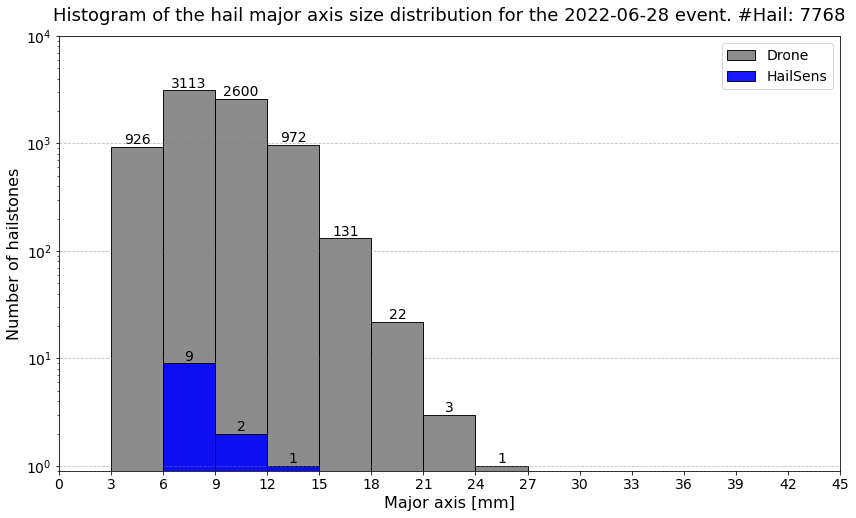

In [14]:
plot_dir = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/plots/20220628/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
        
#Plot real distribution of test dataset man vs machine
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

n_hail_ml = np.sum(~np.isnan(major_ax))

fig, ax = plt.subplots(figsize=[14,8])
fig.patch.set_facecolor('white')

numBins = 14+4
counts, edges, bars = ax.hist([major_ax],numBins,range=[3,45+12],color=['grey'],alpha=0.9, edgecolor='black',label='Drone')
cs, eds, bs = ax.hist([dat_LOM['diameter'].values],numBins,range=[3,45+12],color=['blue'],alpha=0.9, edgecolor='black',label='HailSens')

plt.bar_label(bars)
plt.bar_label(bs)
#ax.hist(data,numBins,range=[2.5,42.5],color='blue',alpha=0.8, edgecolor='black')
plt.title('Histogram of the hail major axis size distribution for the 2022-06-28 event. #Hail: '+str(n_hail_ml),fontsize=18,pad=15)
plt.ylim([0.9,10000])
plt.xlim([0,45])
plt.yscale('log')
plt.grid(axis='y',color='grey',linestyle='--',alpha=0.5)
plt.xticks(np.linspace(0,39+6,14+2))
plt.ylabel('Number of hailstones')
plt.xlabel('Major axis [mm]')
plt.legend(loc='upper right')
plt.savefig(plot_dir+'Hailsize_distribution_major_mask_log.png',dpi=300,bbox_inches='tight',facecolor='white')
plt.show()

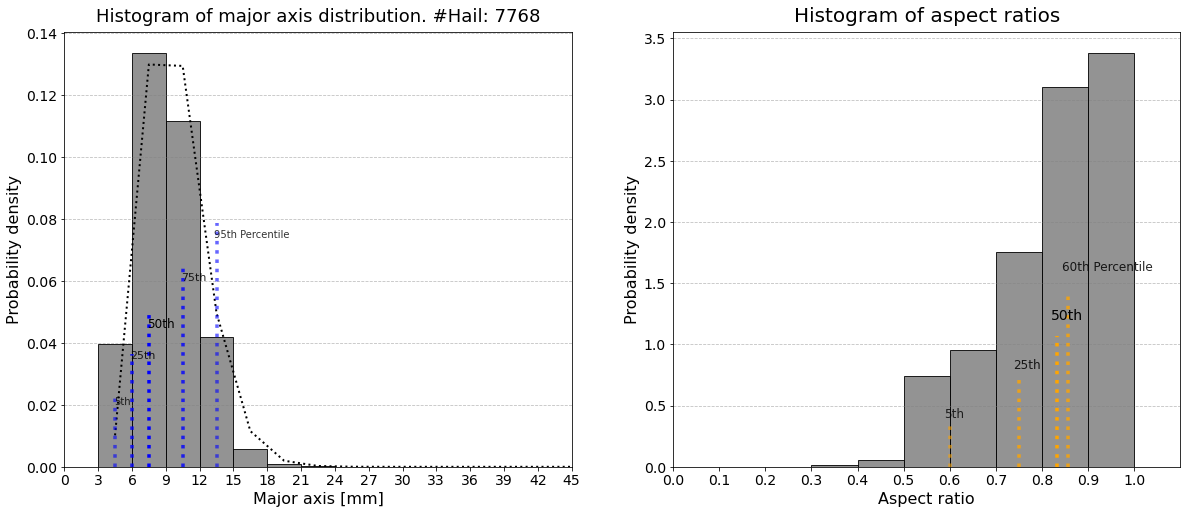

In [34]:
#Plot distribution of major axis and axis ratio with percentiles

n_hail_ml = np.sum(~np.isnan(major_ax))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=[20,8])
fig.patch.set_facecolor('white')

numBins = 14+4
counts, bins, bars = ax1.hist([major_ax],numBins,range=[3,45+12],color=['grey'],alpha=0.85, edgecolor='black',density=True)

#Gamma distribution
a, b, c = scipy.stats.gamma.fit(major_ax[~np.isnan(major_ax)])
best_fit_line = scipy.stats.gamma.pdf(bins, a, b, c)

ax1.plot(bins+1.5, best_fit_line, color='black',linewidth=2, linestyle=':')

# Calculate percentiles
quant_5, quant_25, quant_50, quant_75, quant_95 = np.nanquantile(major_ax, 0.05), np.nanquantile(major_ax, 0.25), np.nanquantile(major_ax, 0.5), np.nanquantile(major_ax, 0.75), np.nanquantile(major_ax, 0.95)

# [quantile, opacity, length]
quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]

# Plot the lines with a loop
for i in quants:
    ax1.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":",color='blue',linewidth=3.5)

ax1.text(quant_5-.1, 0.02, "5th", size = 10, alpha = 0.8,color='black')
ax1.text(quant_25-.13, 0.035, "25th", size = 11, alpha = 0.85,color='black')
ax1.text(quant_50-.13, 0.045, "50th", size = 12, alpha = 1,color='black')
ax1.text(quant_75-.13, 0.06, "75th", size = 11, alpha = 0.85,color='black')
ax1.text(quant_95-.25, 0.074, "95th Percentile", size = 10, alpha =.8,color='black')    
    
#plt.bar_label(bars)
#ax.hist(data,numBins,range=[2.5,42.5],color='blue',alpha=0.8, edgecolor='black')
ax1.set_title('Histogram of major axis distribution. #Hail: '+str(n_hail_ml),fontsize=18,pad=10)
#plt.ylim([1,8000])
ax1.set_xlim([0,45])
#plt.yscale('log')
ax1.grid(axis='y',color='grey',linestyle='--',alpha=0.5)
ax1.set_xticks(np.linspace(0,39+6,14+2))
ax1.set_ylabel('Probability density')
ax1.set_xlabel('Major axis [mm]')

aspect_ratio = minor_ax/major_ax

numBins2 = 10
counts, bins, bars = ax2.hist([aspect_ratio],numBins2,range=[0,1],color=['grey'],alpha=0.85, edgecolor='black',density=True)

#Gamma distribution
#a, b, c = scipy.stats.gamma.fit(aspect_ratio[~np.isnan(aspect_ratio)])
#best_fit_line = scipy.stats.gamma.pdf(bins, a, b, c)

#plt.plot(bins+1.5, best_fit_line, color='black',linewidth=2, linestyle=':')

# Calculate percentiles
quant_5, quant_25, quant_50, quant_60 = np.nanquantile(aspect_ratio, 0.05), np.nanquantile(aspect_ratio, 0.25), np.nanquantile(aspect_ratio, 0.50), np.nanquantile(aspect_ratio, 0.60)

# [quantile, opacity, length]
quants = [[quant_5, 0.6, 0.1], [quant_25, 0.8, 0.2], [quant_50, 1, 0.3], [quant_60, 0.8, 0.4]]

# Plot the lines with a loop
for i in quants:
    ax2.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":",color='orange',linewidth=3.5)

ax2.text(quant_5-.013, 0.4, "5th", size = 12, alpha = 0.8,color='black')
ax2.text(quant_25-.013, 0.8, "25th", size = 12, alpha = 0.85,color='black')
ax2.text(quant_50-.013, 1.2, "50th", size = 14, alpha = 1,color='black')
ax2.text(quant_60-.013, 1.6, "60th Percentile", size = 12, alpha = 0.85,color='black')

#plt.bar_label(bars)
#ax.hist(data,numBins,range=[2.5,42.5],color='blue',alpha=0.8, edgecolor='black')
ax2.set_title('Histogram of aspect ratios',fontsize=20,pad=10)
#plt.ylim([1,8000])
ax2.set_xlim([0,1.1])
#plt.xscale('log')
ax2.grid(axis='y',color='grey',linestyle='--',alpha=0.5)
ax2.set_xticks(np.linspace(0,1,11))
ax2.set_ylabel('Probability density')
ax2.set_xlabel('Aspect ratio')

#plt.legend(loc='upper right')
plt.savefig(plot_dir+'HSD_major_axis_and_aspect_ratio.png',dpi=300,bbox_inches='tight',facecolor='white')
plt.show()

In [31]:
#Count number of rotated bboxes
count = 1
for i,k in enumerate(major_ax):
    s = str(k)
    if len(s) > 5:
        count = count+1
        #print(i)
print(count)     

249
